## Develop segmentation method 

In [34]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import skimage.segmentation as segmentation
import skimage.filters as filters
import skimage.color as color

In [4]:
# Local imports
sys.path.insert(0, 'src')
import utils
from utils import read_json, read_lists, save_image
from utils.model_utils import quick_predict, prepare_device
from utils import visualizations
from utils import segmentation_utils
from parse_config import ConfigParser
from data_loader import data_loaders
import model.model as module_arch

In [49]:
# Define constants, paths
config_path = 'configs/debug/cinic10_imagenet_edit_knn_debug.json'
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
image_path = 'data/cinic-10-imagenet/train/dog/n02114712_211.png'

save_dir_root = os.path.join('saved', 'segmentations')
if not os.path.isdir(save_dir_root):
    os.makedirs(save_dir_root)
    
data_save_path = os.path.join(save_dir, 'data.pth')
image_save_dir = os.path.join(save_dir, 'modified_images')
print(type(os.path.dirname(image_path)))

target_class = os.path.basename(os.path.dirname(image_path))
split = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
image_id = "{}_{}".format(
    split,
    os.path.basename(os.path.splitext(image_path)[0]))
save_paths_dir = os.path.join('paths', 'edits', target_class, image_id)
print(save_paths_dir)


<class 'str'>
paths/edits/dog/train_n02114712_211


In [6]:
# Load config file, and class names file
config_json = read_json(config_path)
config = ConfigParser(config_json)
class_names = read_lists(class_list_path)

device, device_ids = prepare_device(config['n_gpu'])

### Segment Image

#### Define functions

In [12]:
def calculate_change(anchor, data, abs_val=True):
    '''
    Calculate change between all data points and anchor
    
    Arg(s):
        anchor : C-dim np.array
            one data point (e.g. originally predicted logits)
        data : N x C np.array
            multiple data points
        abs_val : boolean
            if True, return absolute values of differences
    
    Returns:
        deltas : N x C np.array
            array of same shape as data computing the change between all data and anchor
    '''
    
    deltas = data - np.broadcast_to(anchor, shape=data.shape)
    
    if abs_val:
        return np.abs(deltas)
    else:
        return deltas

def get_most_changed_idxs(anchor, data, target=None, verbose=False):
    '''
    Given data, return dictionary with indices of data that is 
        1. most changed overall
        2. most changed in predicted class

    Arg(s):
        anchor : C-dim np.array or torch.tensor
            the original predictions
        data : N x C np.array or torch.tensor
            N is number of data points
            C is number of classes
        target : int
            index of desired class
        verbose : boolean
            If true, print out a lot of stuff
    
    Returns:
        dict[str] : int
    '''

    if torch.is_tensor(anchor):
        anchor = anchor.cpu().numpy()
    if torch.is_tensor(data):
        data = data.cpu().numpy()

    # Get the original prediction and its logits values
    original_prediction = np.argmax(anchor)
    original_prediction_logits = anchor[:, original_prediction]
    
    # Determine which modified index has the most change in the predicted class
    modified_predicted_logits = data[:, original_prediction]
    delta_predicted_logits = modified_predicted_logits - original_prediction_logits
    idx_predicted_directional = np.argmin(delta_predicted_logits)  # want index of most decrease
    idx_predicted = np.argmax(np.abs(delta_predicted_logits))
    
    if verbose:
        print("Original prediction is {} (logits: {})".format(original_prediction, original_prediction_logits))
        print("Logits for all modified images for prediction {}: {}".format(original_prediction, modified_predicted_logits))
        print("Idx for largest decrease in predicted class: {}".format(idx_predicted_directional))
        print("Idx for largest absolute change: {}".format(idx_predicted))
    
    # Determine which modified index has most change in logits overall
    change_logits = np.abs(data - np.broadcast_to(original_prediction_logits, shape=data.shape))
    sum_change_logits = np.sum(change_logits, axis=1)
    idx_overall = np.argmax(sum_change_logits)
    if verbose:
        print("Overall changes in logits for each modification: {}".format(sum_change_logits))
    
    if target is None:
        return {
            "predicted": idx_predicted, 
            "predicted-directional": idx_predicted_directional,
            "overall": idx_overall
               }
    
    # Obtain logits for target class
    original_target_logits = anchor[:, target]
    modified_target_logits = data[:, target]
    
    delta_target_logits = modified_target_logits - original_target_logits
    # Determine idx with most positive change in target class and largest absolute value change in target class
    idx_target_directional = np.argmax(delta_target_logits)
    idx_target = np.argmax(np.abs(delta_target_logits))
    if verbose:
        print("Original logits for target class ({}): {}".format(target, original_target_logits))
        print("Logits for target class ({}): {}".format(target, modified_target_logits))
        print("Directional index: {} non-directional index: {}".format(idx_target_directional, idx_target))

    # Determine which modified idx has most change in target (increase) and predicted (decrease) (directional)
    delta_target_predicted_logits_directional = delta_target_logits - delta_predicted_logits
    idx_target_predicted_directional = np.argmax(delta_target_predicted_logits_directional)

    # Determine which modified idx has the most net change in target and predicted (non-directional)
    delta_abs_target_logits = np.abs(delta_target_logits)
    delta_target_predicted_logits = delta_predicted_logits + delta_target_logits
    idx_target_predicted = np.argmax(delta_target_predicted_logits)
    
    if verbose:
        print("\nChange in logits:")
        print("Target: {}".format(delta_target_logits))
        print("Pred: \t{}".format(delta_predicted_logits))
        print("Both: \t{}".format(delta_target_predicted_logits_directional))

    return {
        "predicted-absolute": idx_predicted, 
        "predicted-directional": idx_predicted_directional,
        "target-absolute": idx_target,
        "target-directional": idx_target_directional,
        "target-predicted-absolute": idx_target_predicted,
        "target-predicted-directional": idx_target_predicted_directional,
        "overall": idx_overall,
    }
        


In [7]:
image_path = 'data/cinic-10-imagenet/train/dog/n02114712_211.png'
image = utils.load_image(image_path)
split = os.path.basename(os.path.dirname(os.path.dirname(image_path)))
class_name = os.path.basename(os.path.dirname(image_path))
file_name = os.path.basename(image_path).split(".")[0]
image_name = "{}-{}-{}".format(split, class_name, file_name)
save_dir = os.path.join(save_dir_root, image_name)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
print("Made save directory at {}".format(save_dir))

# Set parameters for segmentation
felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Set segmentation methods
# method = 'felzenszwalb'
# segmentation_params = felzenszwalb_params
methods = []
methods.append(('felzenszwalb', felzenszwalb_params))
methods.append(('quickshift', quickshift_params))
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))

Made save directory at saved/segmentations/train-dog-n02114712_211


In [8]:
# Segment image using each method and modify each segment
segmentations = []
gaussian_modified_images = []
masked_modified_images = []

for method, params in methods:
    segments = segmentation_utils.segment(
        image,
        method=method,
        kwargs=params)
    segmentations.append(segments)

    # Modify segments with noise
    gaussian_modified_images.append(segmentation_utils.modify_segments(
        image,
        segments=segments,
        method='gaussian_noise',
        mean=0,
        std=0.1))

    # Modify segments with masking
    masked_modified_images.append(segmentation_utils.modify_segments(
        image=image,
        segments=segments,
        method='mask'))

save_data = {
    "original_image": image,  # np.array
    "segmentation_methods": methods,  # list[(str, dict)]
    "segmentations": segmentations,  # list[np.array]
    "gaussian_modified_images": gaussian_modified_images,  # list[list[np.array]]
    "masked_modified_images": masked_modified_images  # list[list[np.array]]
}

torch.save(save_data, data_save_path)
print("Segmentation data saved to {}".format(data_save_path))

KWargs: {'mean': 0, 'std': 0.1}
KWargs: {}
KWargs: {'mean': 0, 'std': 0.1}
KWargs: {}
KWargs: {'mean': 0, 'std': 0.1}
KWargs: {}
KWargs: {'mean': 0, 'std': 0.1}
KWargs: {}
Segmentation data saved to saved/segmentations/train-dog-n02114712_211/data.pth


#### Visualizations


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

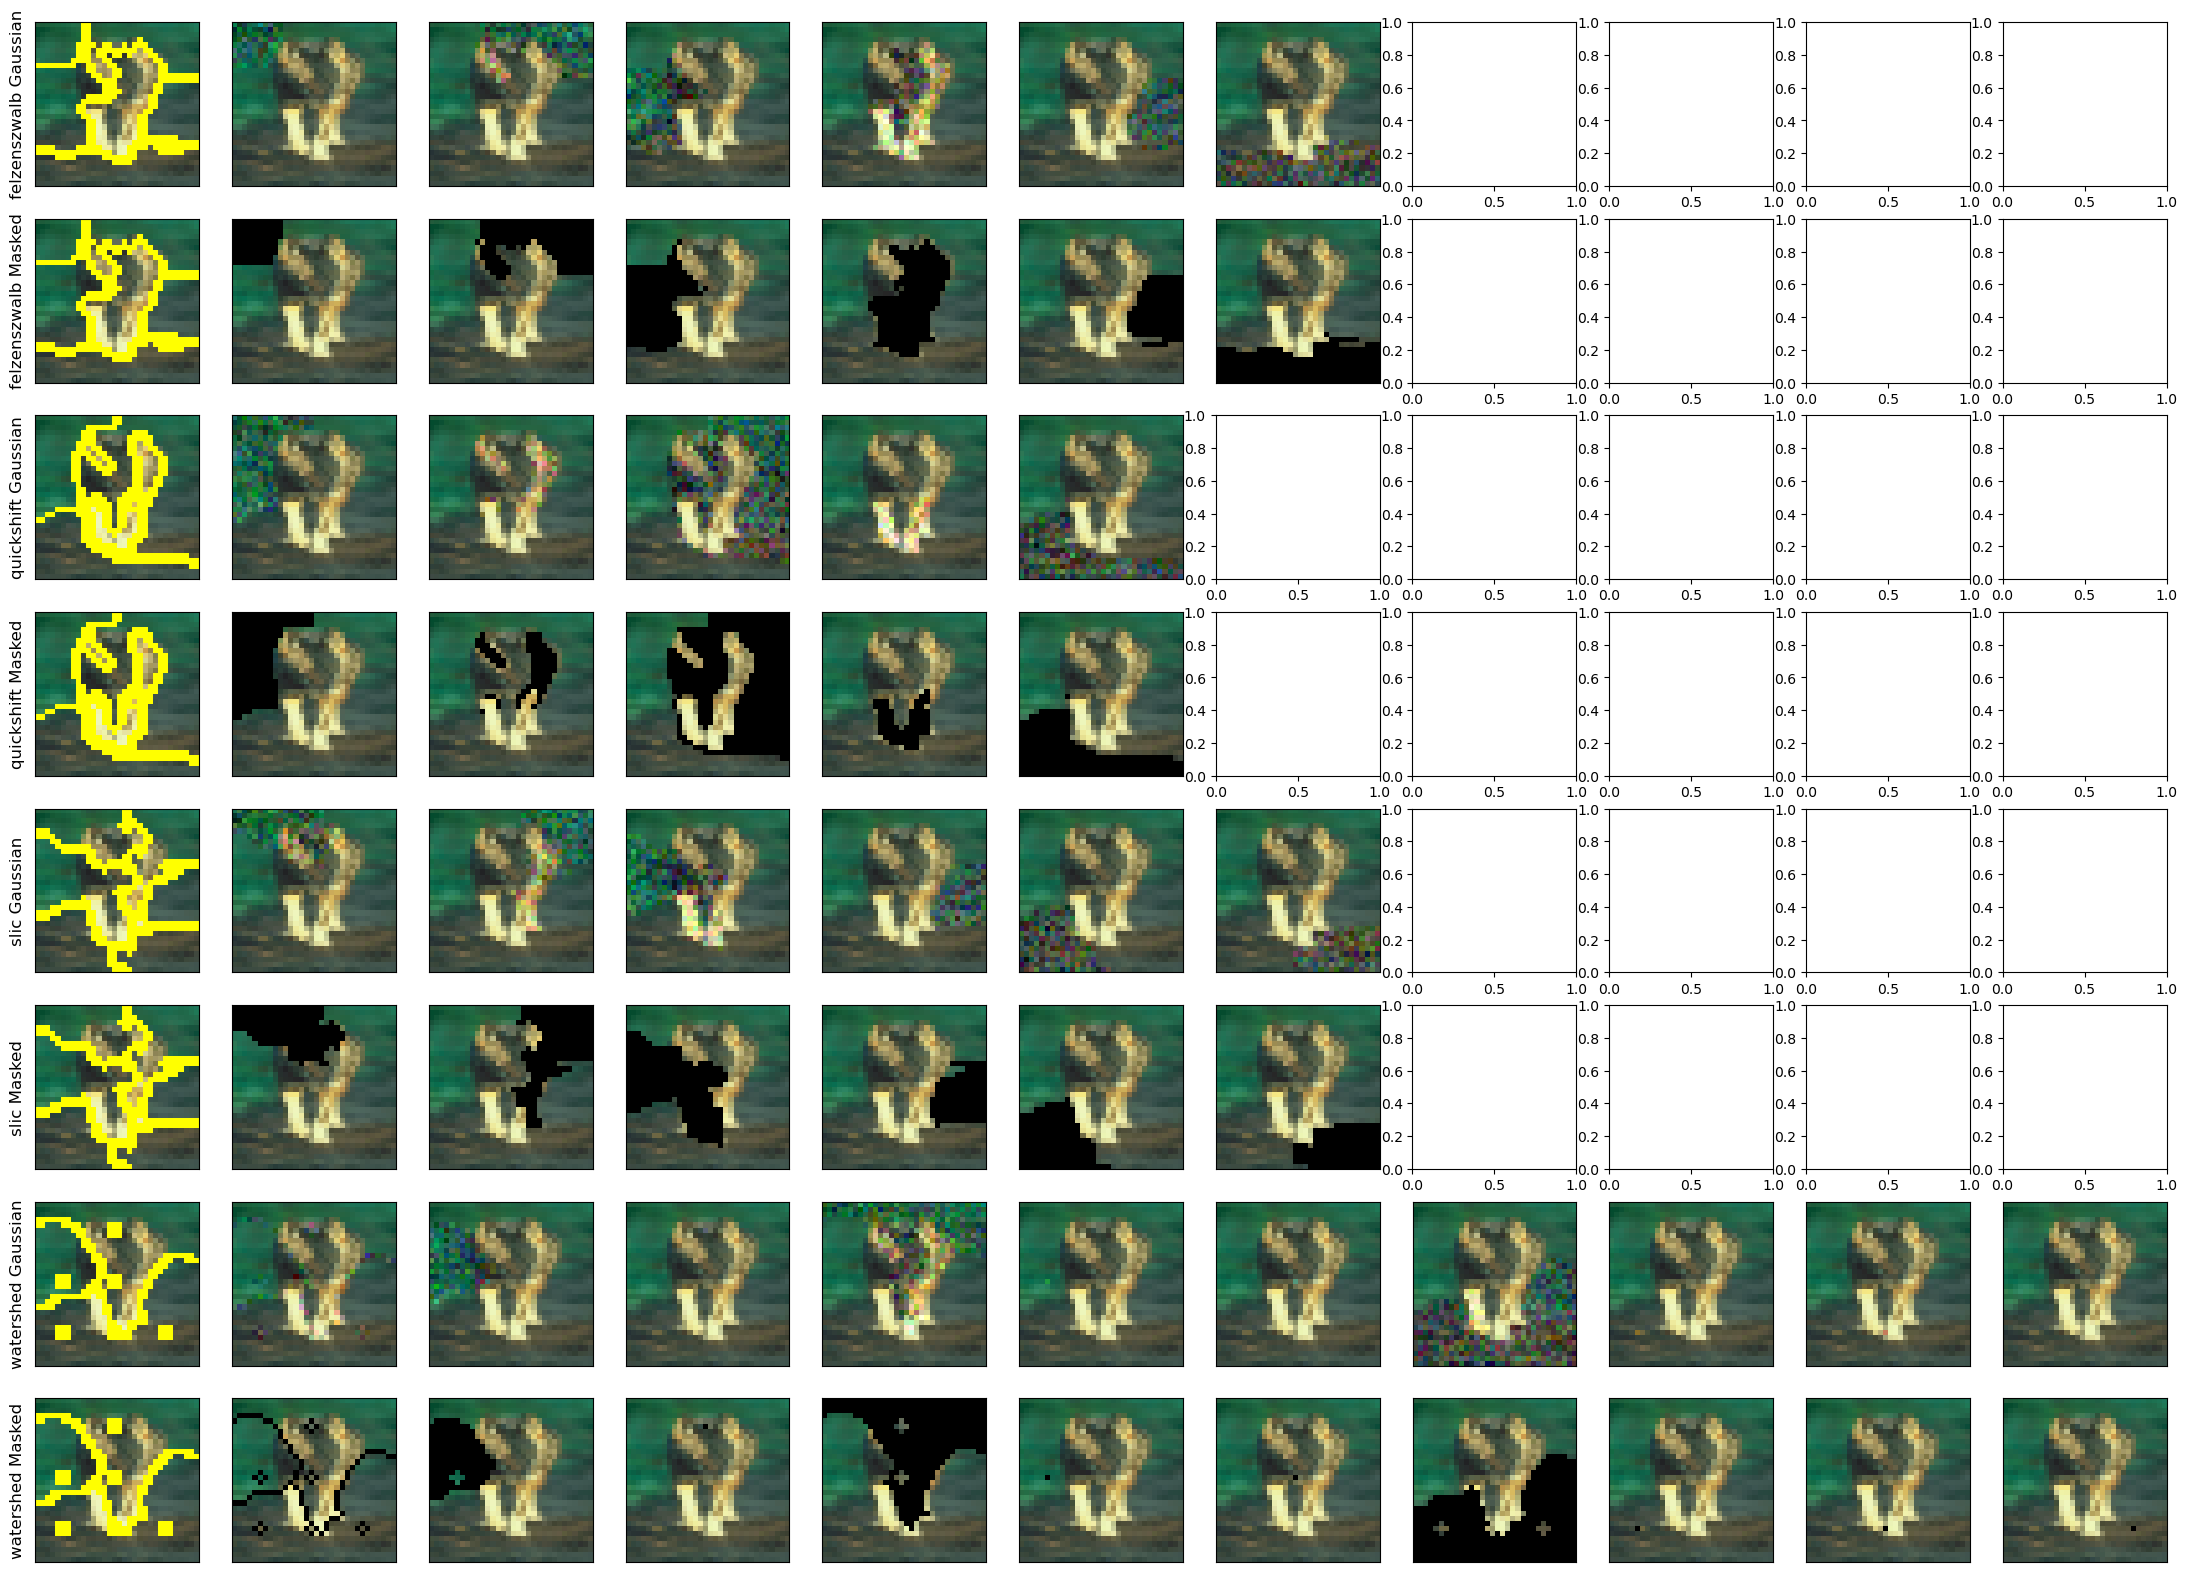

In [25]:
visualization_grid = []
row_labels = []
max_row_len = 0
for idx, (method, _) in enumerate(methods):
    cur_segmentation = segmentations[idx]
    segmentation_overlay = segmentation.mark_boundaries(np.transpose(image, axes=[1, 2, 0]), cur_segmentation)
    # overlay segmentation onto image
    gaussian_modified_row = gaussian_modified_images[idx]
    masked_modified_row = masked_modified_images[idx]
    
    # Top row will be for Gaussian
    row_labels.append(method + ' Gaussian')
    row_images = [segmentation_overlay] + gaussian_modified_row 
    visualization_grid.append(row_images)
    
    # Bottom row will be for masked
    row_labels.append(method + ' Masked')
    row_images = [segmentation_overlay] + masked_modified_row
    visualization_grid.append(row_images)
    
    if len(row_images) > max_row_len:
        max_row_len = len(row_images)
        
# Pad extra columns with None
for idx, row in enumerate(visualization_grid):
    n_pad = max_row_len - len(row)
    padding = [None for i in range(n_pad)]
    visualization_grid[idx] = row + padding

for row in visualization_grid:
    assert len(row) == max_row_len
        
# Save path
visualization_save_path = os.path.join(save_dir, 'segment-visualizations.png')
visualizations.show_image_rows(
    images=visualization_grid,
    row_labels=row_labels,
    save_path=visualization_save_path)

### Load model and run images through the model

In [9]:
# Load model
layernum = config.config['layernum']
model = config.init_obj('arch', module_arch, layernum=layernum)
model.eval()

CIFAR10PretrainedModelEdit(
  (model): VGG(
    (normalize): InputNormalize()
    (layer0): Sequential(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (layer3): Sequential(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, moment

In [10]:
# Load the checkpoint with keys 
# save_path = os.path.join('temp', '{}.pth'.format(image_name))
save_data = torch.load(data_save_path)

# Unpack data
original_image = save_data['original_image']
original_image = np.expand_dims(original_image, axis=0)
original_image = torch.from_numpy(original_image).type(torch.FloatTensor).to(device)
methods = save_data['segmentation_methods']
all_gaussian_modified_images = save_data['gaussian_modified_images']
all_masked_modified_images = save_data['masked_modified_images']

# Create lists for storing logits
all_gaussian_modified_logits = []
all_masked_modified_logits = []

# Target class
target = 5  # 5 = dog

Current segmentation method: felzenszwalb
all predictions: tensor([5, 4, 6, 6, 6, 6, 5, 5, 3, 3, 6, 6], device='cuda:0')
success_idxs: tensor([0, 6, 7], device='cuda:0')
Current segmentation method: quickshift
all predictions: tensor([2, 6, 6, 6, 6, 5, 2, 7, 6, 6], device='cuda:0')
success_idxs: tensor([5], device='cuda:0')
Current segmentation method: slic
all predictions: tensor([5, 6, 6, 6, 6, 6, 5, 4, 3, 6, 6, 6], device='cuda:0')
success_idxs: tensor([0, 6], device='cuda:0')
Current segmentation method: watershed
all predictions: tensor([6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 2, 5, 6, 2, 6, 6, 6, 6, 6, 6],
       device='cuda:0')
success_idxs: tensor([11], device='cuda:0')
['felzenszwalb_gaussian_0.png', 'felzenszwalb_masked_0.png', 'felzenszwalb_masked_1.png', 'quickshift_masked_0.png', 'slic_gaussian_0.png', 'slic_masked_0.png', 'watershed_masked_1.png']
7
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to 

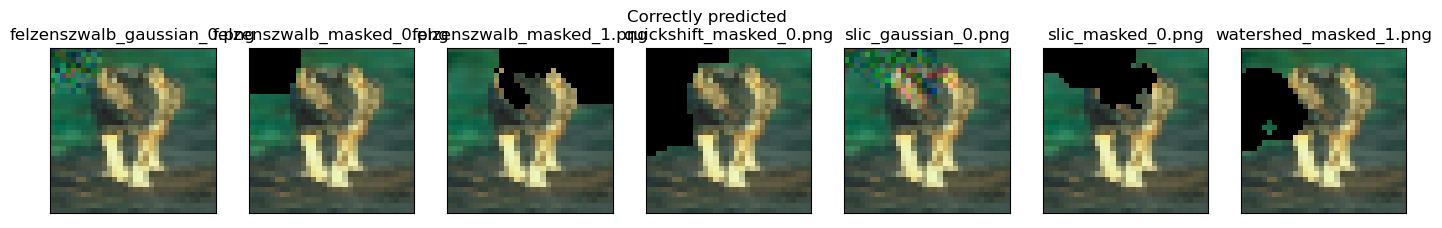

In [36]:
# Pass original image through first to get logits

with torch.no_grad():
    original_logits = model(original_image)
    original_logits = original_logits.cpu().numpy()

success_modifications = []  # store images
success_names = []  # store strings

original_image_numpy = np.squeeze(original_image.cpu().numpy())
# Pass images through model to get predictions
for idx, (method, _) in enumerate(methods):
    print("Current segmentation method: {}".format(method))
    
    # Index into current modified images
    gaussian_modified_images = all_gaussian_modified_images[idx]
    masked_modified_images = all_masked_modified_images[idx]
    n_modified = len(gaussian_modified_images)
    # Stack along batch dimension
    all_images = np.stack(gaussian_modified_images + masked_modified_images, axis=0)
    # Convert to tensor & switch to GPU
    all_images = torch.from_numpy(all_images).type(torch.FloatTensor)
    all_images = all_images.to(device)
    
    # Forward through model
    with torch.no_grad():
        all_logits = model(all_images)
        
    # Obtain indices where the prediction is the target
    all_predictions = torch.argmax(all_logits, dim=1)
    success_idxs = (all_predictions == target).nonzero().squeeze(dim=-1)
    
    # Store images in respective list
    success_images = all_images[success_idxs]
    # If only one image, expand dims to be 1 x C x H x W
    if len(success_images.shape) == 3:
        success_images = torch.unsqueeze(success_images, dim=0)
    success_modifications.append(success_images)
    
    # Store names of each image in respective list
    if success_idxs.shape[0] != 0:
        for idx in success_idxs:
            if idx < n_modified:
                mod_type = 'gaussian'
            else: 
                mod_type = 'masked'
            name = "{}_{}_{}.png".format(method, mod_type, idx % n_modified)
            success_names.append(name)
            
    
    print("all predictions: {}".format(all_predictions))
    print("success_idxs: {}".format(success_idxs))
    
    # Separate modified logits from one another and append to respective lists
    gaussian_modified_logits = all_logits[0:n_modified].cpu().numpy()
    masked_modified_logits = all_logits[n_modified:].cpu().numpy()
    # Add to master lists
    all_gaussian_modified_logits.append(gaussian_modified_logits)
    all_masked_modified_logits.append(masked_modified_logits)
    
    # Get indices for gaussian noise modifications with most change
    gaussian_indices = get_most_changed_idxs(
        anchor=original_logits,
        data=gaussian_modified_logits,
        target=target)
    
    # Get indices for masked modifications with most change
    masked_indices = get_most_changed_idxs(
        anchor=original_logits,
        data=masked_modified_logits,
        target=target)
    
# Visualize the successful modifications
success_modifications = torch.cat(success_modifications, dim=0).cpu().numpy()
print(success_names)
print(modifications.shape[0])
visualizations.show_image_rows(
    images=[list(success_modifications)],
    image_titles=[success_names],
    figure_title='Correctly predicted')
    

In [43]:
# Save images

def save_image(image, save_path):
    '''
    Given the image, save as PNG to save_path

    Arg(s):
        image : np.array
            image to save
        save_path : str
            location in file system to save to

    Returns:
        None
    '''
    # Create save directory if it doesn't already exist
    utils.ensure_dir(os.path.dirname(save_path))

    # Convert to integer values
    if image.dtype == np.float32:
        image = image * 255.0
        image = image.astype(np.uint8)
    # Transpose if in format of C x H x W to H x W x C
    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    # Convert array -> image and save
    image = Image.fromarray(image)
    image.save(save_path)
    
for name, image in zip(success_names, success_modifications):
    print(image.shape)
    # image = np.transpose(image, (1, 2, 0))
    save_path = os.path.join(image_save_dir, name)
    save_image(image, save_path)

(3, 32, 32)
float32
(3, 32, 32)
float32
(3, 32, 32)
float32
(3, 32, 32)
float32
(3, 32, 32)
float32
(3, 32, 32)
float32
(3, 32, 32)
float32


### Analyze results

[[-2.000988  -0.6544444  1.2874204  0.7075564  0.4487721  1.2149683
   3.0439496 -1.4309834 -0.7479153 -1.8682877]]


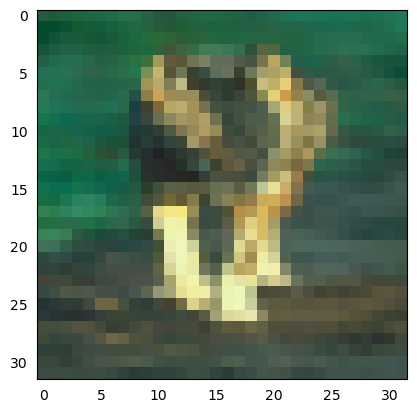

For Gaussian noise modifications:
original class prediction: 6
{'target': 3, 'overall': 3}


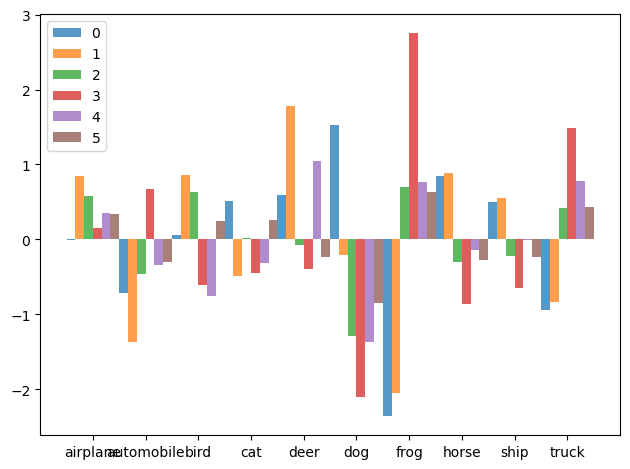

0's logits: [-2.0061684  -1.3720217   1.3402797   1.2193959   1.041149    2.7452228
  0.6853828  -0.5881869  -0.25359797 -2.8114052 ]
3's logits: [-1.8483866   0.02222234  0.6796412   0.25782284  0.05183685 -0.8936018
  5.7972574  -2.2871094  -1.3984878  -0.38115042]
For masked modifications:
original class prediction: 6


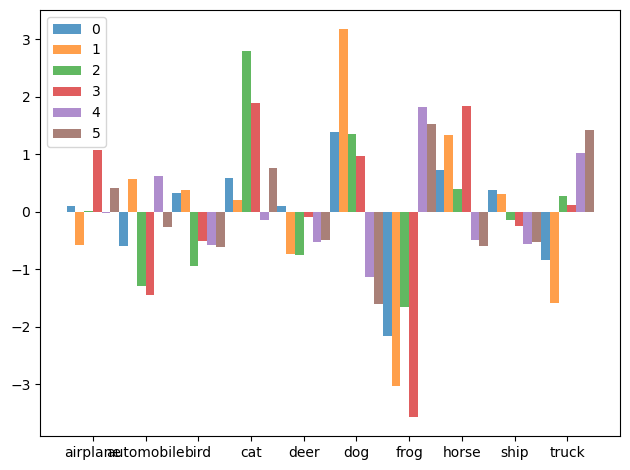

Original logits: [[-2.000988  -0.6544444  1.2874204  0.7075564  0.4487721  1.2149683
   3.0439496 -1.4309834 -0.7479153 -1.8682877]]
Target: 3's logits: [-1.8483866   0.02222234  0.6796412   0.25782284  0.05183685 -0.8936018
  5.7972574  -2.2871094  -1.3984878  -0.38115042]
Overall: 1's logits: [-1.1493732  -2.018152    2.1474168   0.22173576  2.2331645   1.010762
  0.9990027  -0.5422446  -0.2005576  -2.701706  ]
{'target': 3, 'overall': 1}


In [30]:
# Save logits in save_data
# save_data['original_logits'] = original_logits
# save_data['gaussian_modified_logits'] = all_gaussian_modified_logits
# save_data['masked_modified_logits'] = all_masked_modified_logits
# torch.save(save_data, data_save_path)
# print("Saved logits data at {}".format(data_save_path))

# Get most changed indices for gaussian modification
# print("For Gaussian noise modifications:")
# gaussian_changed_indices = get_most_changed_idxs(
#     np.concatenate([original_logits, gaussian_modified_logits], axis=0))
# print(gaussian_changed_indices)
# gaussian_deltas = calculate_change(
#     anchor=original_logits,
#     data=gaussian_modified_logits,
#     abs_val=False)
# visualizations.bar_graph(gaussian_deltas, x_labels=class_names)
# print("0's logits: {}".format(gaussian_modified_logits[0]))
# print("3's logits: {}".format(gaussian_modified_logits[3]))
# # visualizations.bar_graph(
# #     np.concatenate([original_logits, gaussian_modified_logits], axis=0),
# #     labels=class_names
# # )

# print("For masked modifications:")
# masked_changed_indices = get_most_changed_idxs(
#     np.concatenate([original_logits, masked_modified_logits], axis=0))
# masked_deltas = calculate_change(
#     anchor=original_logits,
#     data=masked_modified_logits,
#     abs_val=False)
# visualizations.bar_graph(masked_deltas, x_labels=class_names)
# print("Original logits: {}".format(original_logits))
# print("Target: {}'s logits: {}".format(masked_changed_indices["target"], gaussian_modified_logits[masked_changed_indices["target"]]))
# print("Overall: {}'s logits: {}".format(masked_changed_indices["overall"], gaussian_modified_logits[masked_changed_indices["overall"]]))
# # visualizations.bar_graph(
# #     np.concatenate([original_logits, masked_modified_logits], axis=0),
# #     labels=class_names
# # )
# print(masked_changed_indices)

torch.Size([7, 10])
width: 0.14285714285714285


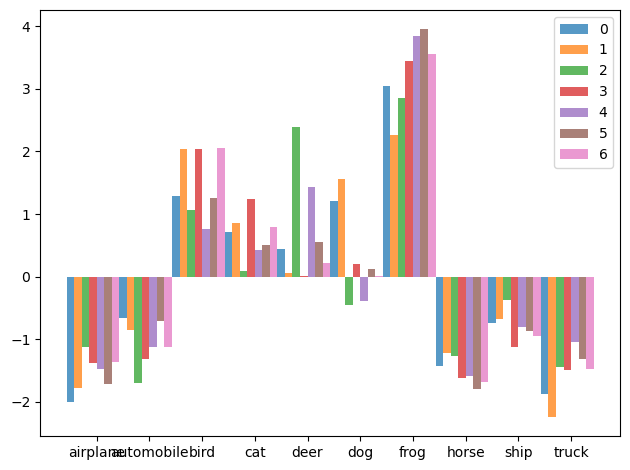

{'target': 4, 'overall': 1}


In [7]:
# # load numbers from checkpoint
# logits = torch.load('temp/gaussian_noise_mod_logits.pth', map_location=torch.device('cpu'))
# classes = utils.read_lists('metadata/cinic-10/class_names.txt')
# print(logits.shape)
# bar_graph(logits, labels=classes)
# # bar_graph(torch.unsqueeze(logits[0], dim=0))
# indices = get_most_changed_idxs(logits)
# print(indices)


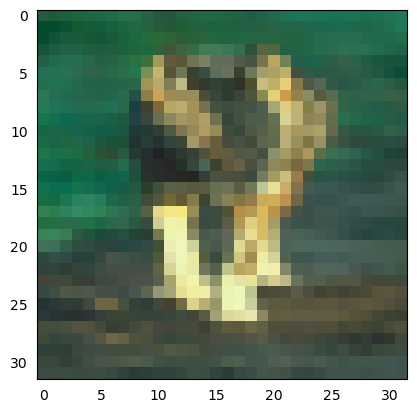

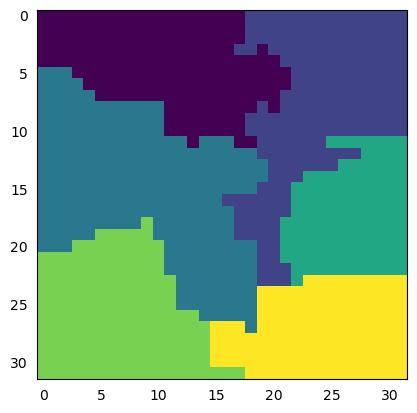

KWargs: {}
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


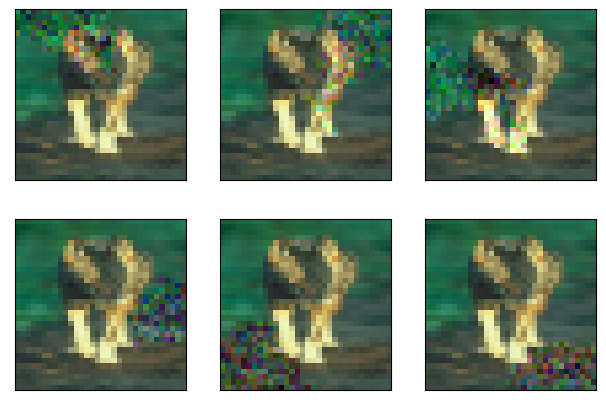

(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


In [173]:
# # Get segmentation of image
# image = utils.load_image('data/cinic-10-imagenet/train/dog/n02114712_211.png')
# slic_params = {
#     'n_segments': 10,
# }
# segments = segment(
#     image,
#     method='slic',
#     params=slic_params)

# visualizations.show_image(image)
# visualizations.show_image(segments)
# # modified_images = modify_segments(
# #     image=image,
# #     segments=segments,
# #     method='mask')

# # Modify each segment 1 by 1
# modified_images = modify_segments(
#     image=image,
#     segments=segments,
#     method='gaussian_noise')

# modified_images_grid = visualizations.make_grid(modified_images, items_per_row=3)
# visualizations.show_image_rows(modified_images_grid)
# # Add original image to images list and stack
# images = [image] + modified_images
# images = torch.from_numpy(np.stack(images, axis=0))
# images = images.type(torch.FloatTensor)
# images = images.to(device)

# # Convert model to evaluation mode
# model.eval()
# with torch.no_grad():
#     logits = model(images)


In [2]:
# # for image_logits in logits:
# #     print(image_logits)
# #     print(torch.argmax(image_logits))

# original_pred = logits[0]
# modified_preds = logits[1:]
# logit_changes = []
# for modified_pred in modified_preds:
    
#     change = original_pred - modified_pred
#     total_change = torch.sum(torch.abs(change))
#     print(change, total_change)
#     logit_changes.append(total_change)

# bar_graph(logits)

NameError: name 'logits' is not defined

In [112]:
# # Pedal to the metal!

# image = utils.load_image('data/cinic-10-imagenet/train/dog/n02114712_211.png')

# felzenszwalb_params = {
#     'scale': 0.9,
#     'sigma': 0.25,
#     'min_size': 50
# }
# quickshift_params = {
#     'max_dist': 25,
#     'kernel_size': 3,
#     'sigma': 0.9,
# }
# slic_params = {
#     'n_segments': 10,
# }

# watershed_params = {
#     'markers': 10,
#     'watershed_line': True
# }

# methods = []
# methods.append(('slic', slic_params))
# methods.append(('watershed', watershed_params))
# # methods.append(('quickshift', {}))
# methods.append(('quickshift', quickshift_params))
# # methods.append(('felzenszwalb', {}))
# methods.append(('felzenszwalb', felzenszwalb_params))

# for method, params in methods:
#     print("Method: {}, params: {}".format(method, params))
#     labels = segment(
#         image,
#         method=method,
#         params=params)
#     uniques = np.unique(labels)
#     print("{} generated {} unique segments".format(method, len(uniques)))
#     print(uniques)
    

Method: slic, params: {'n_segments': 10}
slic generated 6 unique segments
[1 2 3 4 5 6]
Method: watershed, params: {'markers': 10, 'watershed_line': True}
watershed generated 10 unique segments
[0 1 2 3 4 5 6 7 8 9]
Method: quickshift, params: {'max_dist': 25, 'kernel_size': 3, 'sigma': 0.9}
quickshift generated 5 unique segments
[0 1 2 3 4]
Method: felzenszwalb, params: {'scale': 0.9, 'sigma': 0.25, 'min_size': 50}
felzenszwalb generated 6 unique segments
[0 1 2 3 4 5]


# Given an image and a segmentation, mask out each section and return

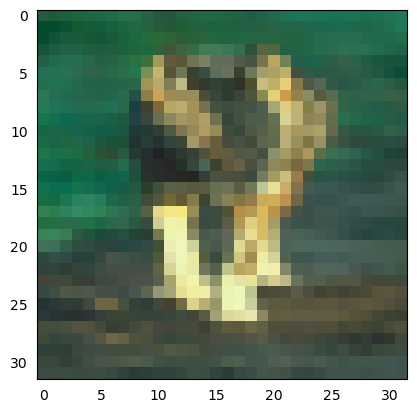

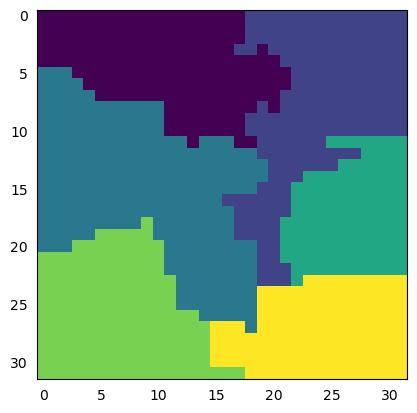

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KWargs: {}


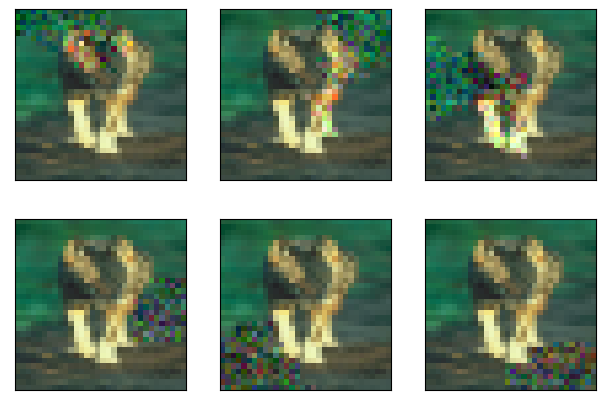

In [152]:
# # Test modify_segments()
# image = utils.load_image('data/cinic-10-imagenet/train/dog/n02114712_211.png')

# slic_params = {
#     'n_segments': 10,
# }
# segments = segment(
#     image,
#     method='slic',
#     params=slic_params)

# visualizations.show_image(image)
# visualizations.show_image(segments)
# # modified_images = modify_segments(
# #     image=image,
# #     segments=segments,
# #     method='mask')
# modified_images = modify_segments(
#     image=image,
#     segments=segments,
#     method='gaussian_noise')

# modified_images = visualizations.make_grid(modified_images, items_per_row=3)
# visualizations.show_image_rows(modified_images)

(32, 32)
[0 1 2 3 4 5]


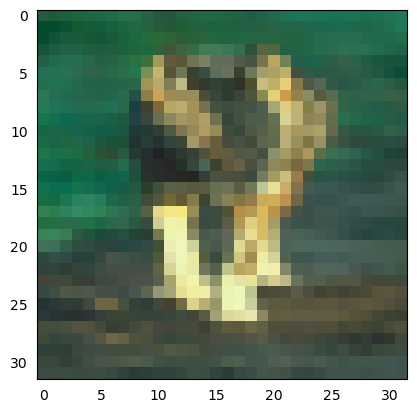

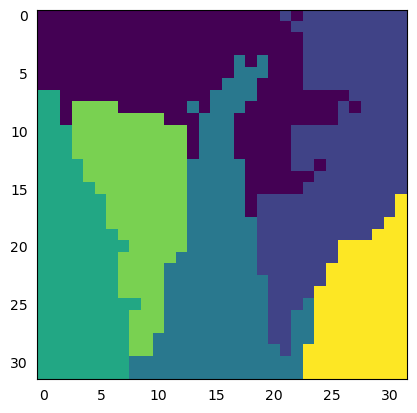

<function print>

In [147]:
print(labels.shape)
# print(type(*labels.shape))
print(np.unique(labels))
# visualizations.show_image_rows(
#     images=[[image, labels]]
# )
visualizations.show_image(image)
visualizations.show_image(labels)
print

# Scale Up to 10 images

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


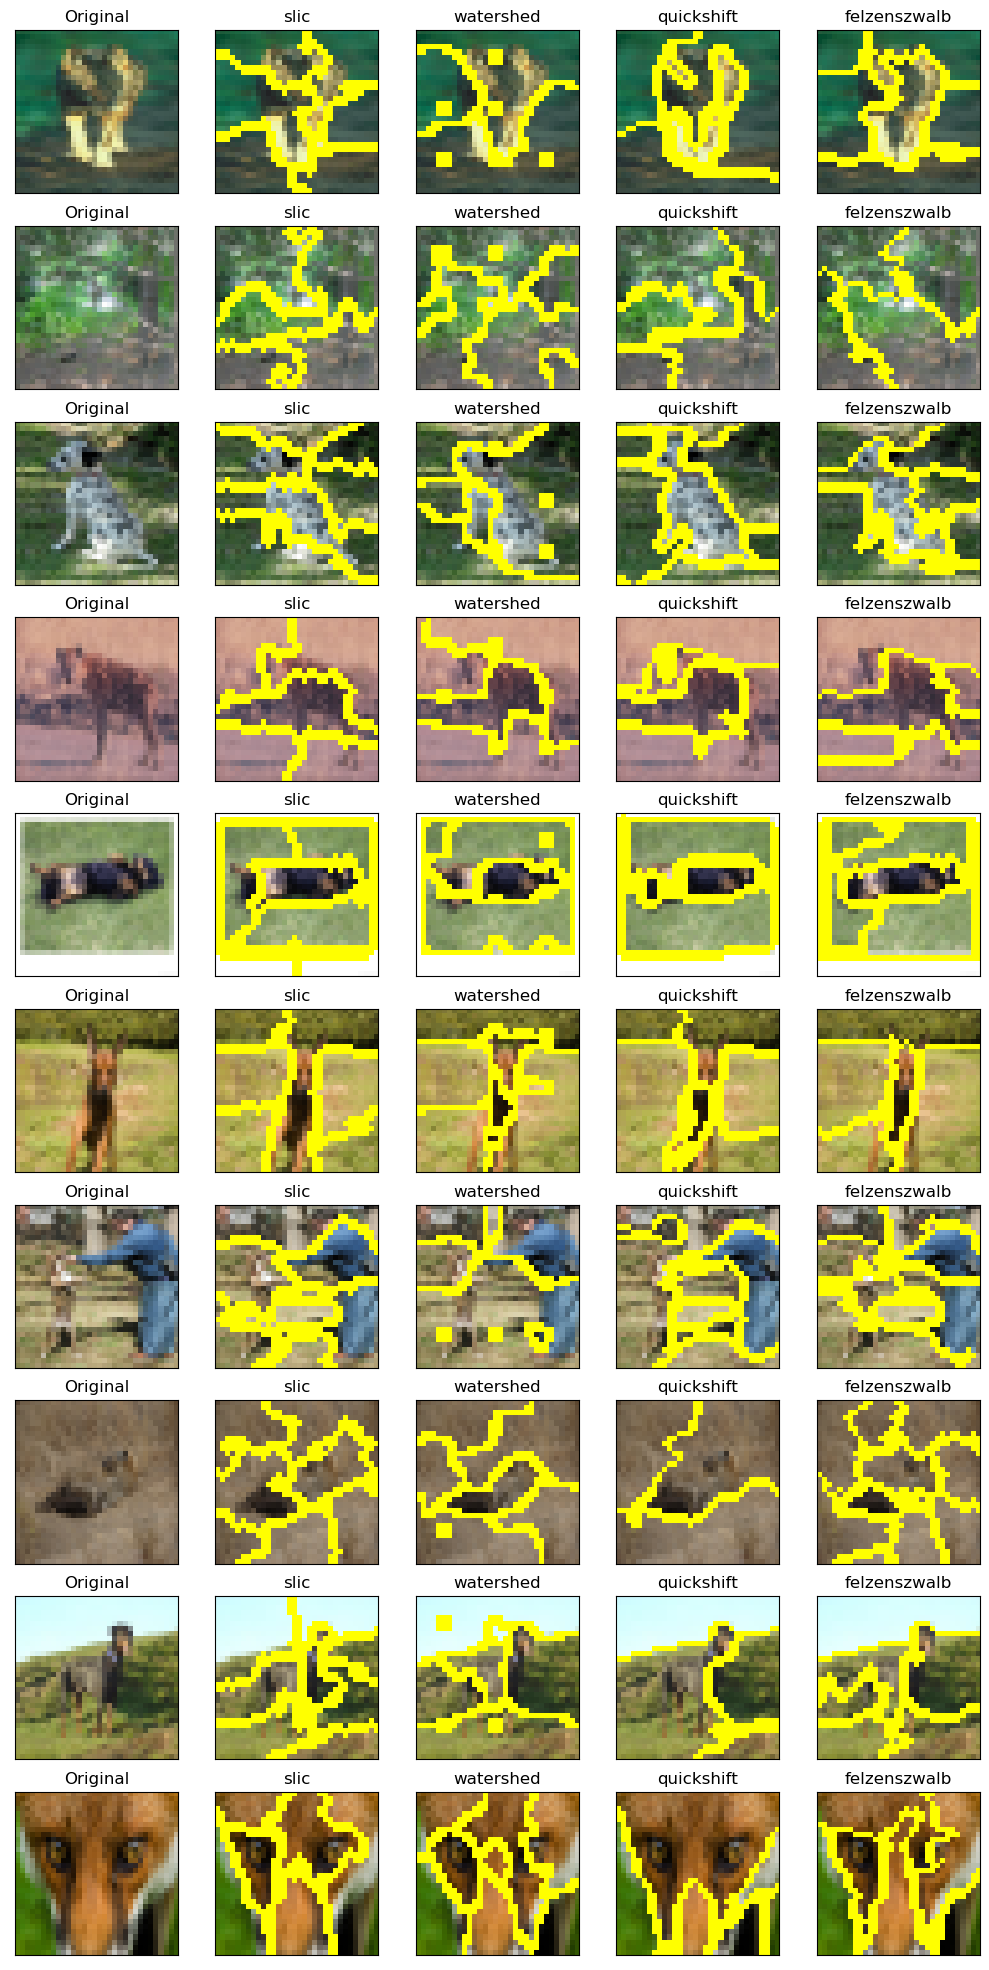

In [119]:
image_paths_path = os.path.join('paths', 'edits', 'dog', 'keys', 'key_image_paths.txt')
image_paths = utils.read_lists(image_paths_path)

felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
quickshift_params = {
    # 'channel_axis': 0,
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
    # 'channel_axis': 0
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Create list of methods and corresponding parameters
methods = []
methods.append(('slic', slic_params))
methods.append(('watershed', watershed_params))
# methods.append(('quickshift', {}))
methods.append(('quickshift', quickshift_params))
# methods.append(('felzenszwalb', {}))
methods.append(('felzenszwalb', felzenszwalb_params))
n_methods = len(methods)

images = []
titles = []

for path in image_paths:
    image = utils.load_image(path)
    images.append(image)
    titles.append('Original')
    for method, method_params in methods:
        labels = segment(
            image,
            method=method,
            params=method_params)

        annotated_image = segmentation.mark_boundaries(np.transpose(image, axes=[1, 2, 0]), labels)
        images.append(annotated_image)
        titles.append(method)

print(type(images[0]))
images = visualizations.make_grid(images, items_per_row=n_methods+1)
titles = visualizations.make_grid(titles, items_per_row=n_methods+1)
print(type(images))
print(type(images[0]))
print(type(images[0][0]))
visualizations.show_image_rows(
    images,
    image_titles=titles)
    # save_path='visualizations/segmentation_comparison.png')